# Análisis Model de Edificaciones con OpenSeesPy
---
## OPENSEES - Open System for Earthquake Engineering Simulation

Es un programa de **licencia libre** y **código abierto** que permite analizar y simular estructuras y modelos geométricos bajo cargas gravitacionales y dinámicas.

OpenSees tiene sus orígenes en la tesis doctoral de Francis McKenna. Hoy en día, gracias a las aportaciones de diferentes investigadores, el programa
cuenta que una gran variedad de elementos finitos, materiales y procedimiendos de análisis.

Su lenguaje original es C++, pero utiliza instrucciones en lenguaje TCL (del inglés Tool Command Language). Adicionalmente, **Python cuenta con una libería para usar el programa**.

## ¿Por qué OpenSees?

* Código Abierto
* Librería de materiales, elementos y de analisis
* Desarrollo constante de nuevos modelos numerosos
* No es una caja negra
* El usuario puede modificar a gusto
* Reducido tiempo de analisis
* Acceso gratuito

## Estructura tipica a modelar

1. Dimensiones y grados de libertad
2. Coordenadas de nodos
3. Condiciones de apoyo
4. Materiales
5. Secciones
6. Transformación geométrica
7. Elementos
8. Masas
9. Patrones de carga

## Estructura típica del Análisis

1. Manejo de restricciones
2. Numeración de grados de libertad
3. Estrategia de solución del sistema de ecuaciones
4. Evaluación de convergencia
5. Selección de algoritmo de solución de raíces
6. Esquema de integración con respecto al tiempo
7. Definición de tipo de análisis
8. Ejecución del análisis

```bash
# Instalación de OpenSeesPy

pip install openseespy
```

Documentación: [](https://openseespydoc.readthedocs.io/en/latest)

In [55]:
import openseespy.opensees as ops
import opsvis as opsv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from Functions import *

warnings.filterwarnings("ignore")

In [56]:
# Unidades Base mks
m = 1
kg = 1
s = 1

# Otras Unidades
cm = 0.01*m
#kgf = 9.80665*kg*m/s**2
kgf = 9.81*kg*m/s**2
tonf = 1000*kgf

# Constantes Físicas
#g = 9.80665*m/s**2
g = 9.81*m/s**2

### Iniciando con el modelado

In [57]:
ops.wipe()
ops.model('basic','-ndm',3,'-ndf',6)

### Coordenada de los nodos

```python
ops.node(nodeTag,   # Etiqueta del Nodo
        *crds)      # Coordenadas del Nodo (x,y,z)
```

In [58]:
data1 = pd.read_excel("data.xlsx", sheet_name="nodos")
nodos = data1.to_numpy(dtype=np.float64)

In [59]:
for idx, nodoi in enumerate (nodos):
    ops.node(idx+1, *nodoi)

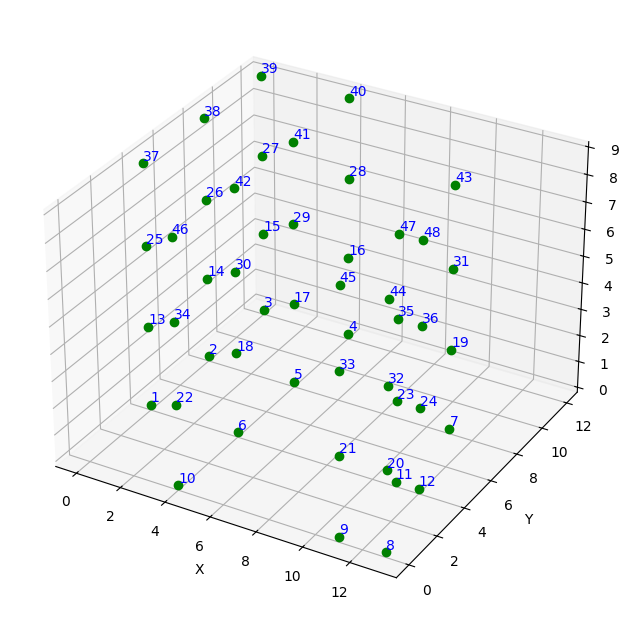

In [60]:
opsv.plot_model(fig_wi_he = (25,20))
plt.show()

```python
ops.fixZ(z,          # Coordenada del plano Z
*constrValues,      # Restricciones [Ux, Uy, Uz, Mx, My, Mz]
'-tol', tol=1e-10)  # Tolerancia
```

```python
ops.fixZ(z,          # Coordenada del plano Z
*constrValues)      # Restricciones [Ux, Uy, Uz, Mx, My, Mz]
```

In [61]:
ops.fixZ(0.0, *[1,1,1,1,1,1])

### Definición de los materiales

In [62]:
fc = 280*kgf/cm**2
E = 150*fc**0.5*kgf/cm**2   # Modulo de elasticidad
G = 0.5*E/(1+0.2)           # Modulo de corte

### Definicion de seccion

In [63]:
# Viga
b, h = 30*cm, 60*cm
Av = b*h
Izv = b*h**3/12
Iyv = b**3*h/12
aa, bb = max(b,h), min(b,h)
B = 1/3-0.21*bb/aa*(1-(bb/aa)**4/12)
Jxxv = B*bb**3*aa

# Columna
a, a = 45*cm, 45*cm
Ac = a*a
Izc = a*a**3/12
Iyc = a**3*a/12
aa, bb = max(a,a), min(a,a)
B = 1/3-0.21*1*(1-(1)**4/12)
Jxxc = B*bb**3*aa

# Densidad del concreto
p = 2400*kg/m**3

```python
ops.element('elasticBeamColumn',    # Tipo de elemento
            eleTag,                 # Etiqueta del elemento
            *eleNodes,              # Etiqueta de los Nodos inicial y final del elemento
            Area,                   # Area de la seccion transversal
            E_mod,                  # Modulo de elasticidad
            G_mod,                  # Modulo de corte
            Jxx,                    # Momento Torsional de inercia
            Iy, Iz,                 # Momento de inercia en los ejes principales
            transfTag,              # Etiqueta de la transformacion geometrica
            <'-mass', mass>)        # Masa por unidad de longitud
```

```python
ops.geomTransf( transfType,     # Tipo de Transformación "Linear" "PDelta" "Corotational"
                transfTag,      # Etiqueta de la Transformación
                *vecxz)         # Vector para orientas los ejes locales
```

In [64]:
CTransform = 1      # Etiqueta de la Transformación para columnas
BTransform = 2      # Etiqueta de la Transformación para vigas

ops.geomTransf("PDelta",CTransform,*[1,0,0])
ops.geomTransf("Linear",BTransform,*[0,0,1])

In [65]:
data2 = pd.read_excel("data.xlsx", sheet_name="elementos")
vigas = data2.to_numpy(dtype=np.float64)
#vigas

In [66]:
# Columnas
for i in range(1, 37):
    ops.element('elasticBeamColumn', i, i, i+12, Ac, E, G, Jxxv, Iyc, Izc, CTransform, '-mass', p*Ac*10**-8)

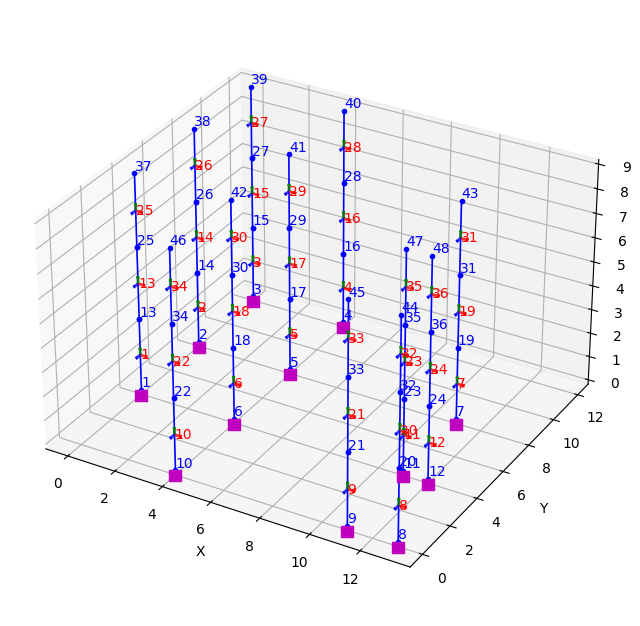

In [67]:
opsv.plot_model(fig_wi_he = (25,20))
plt.show()

In [68]:
# Vigas
for idx, vigai in enumerate(vigas):
    ops.element('elasticBeamColumn', idx+37, *vigai, Av, E, G, Jxxv, Iyv, Izv, BTransform, '-mass', p*Av*10**-8)

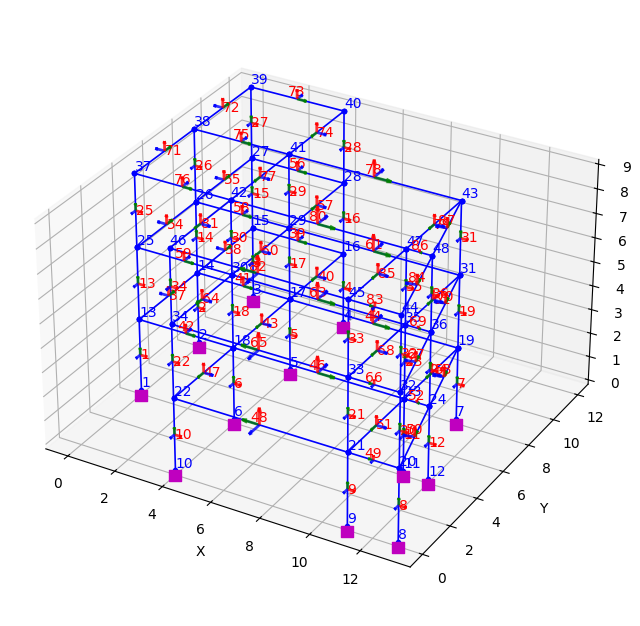

In [69]:
opsv.plot_model(fig_wi_he = (25,20))
plt.show()

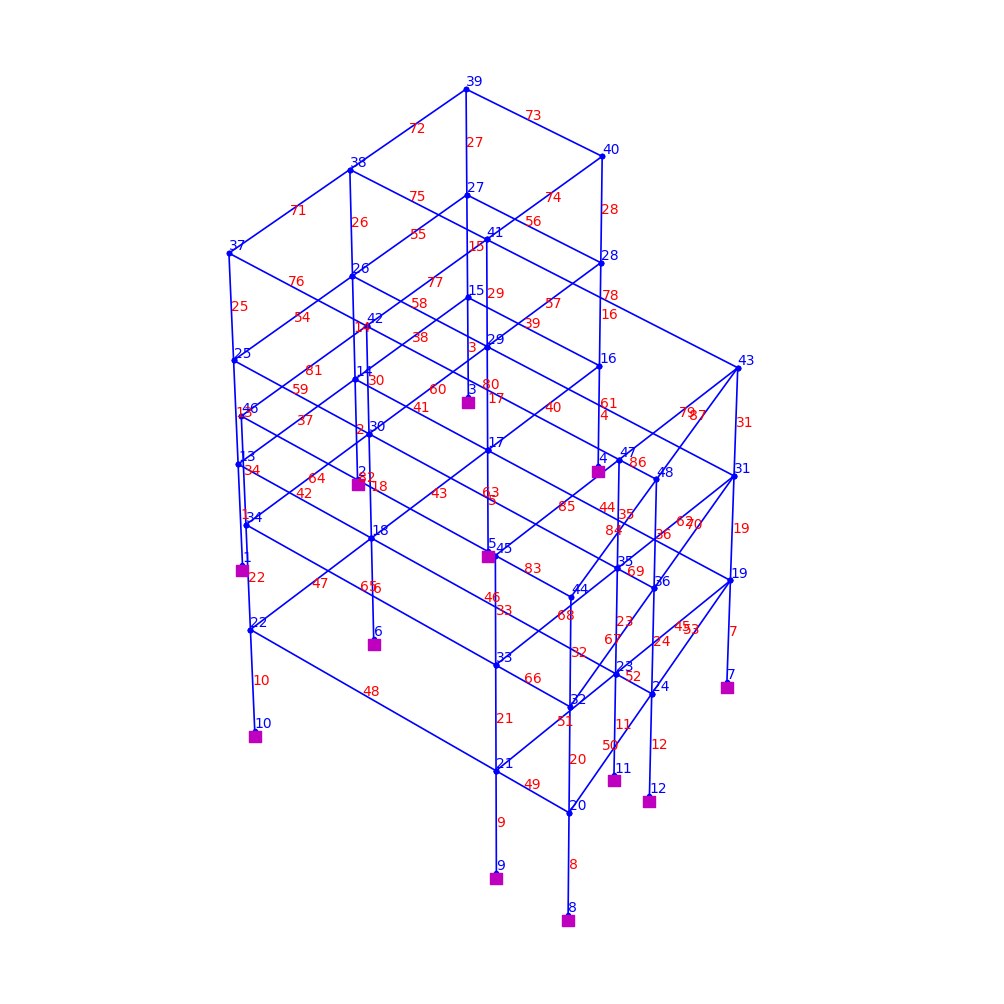

In [70]:
opsv.plot_model(fig_wi_he=(30.,25.),az_el=(-50,40),fig_lbrt=(0, 0, 1, 1),axis_off=1,local_axes=False)
plt.show()

In [71]:
losas = [[0,5,4,1],     # 1
         [1,4,3,2],     # 2
         [5,10,6,4],    # 3
         [9,8,10,5],    # 4
         [8,7,11,10],   # 5
         [10,11,6]]     # 6

losas

areas = np.zeros(12,"f8")

In [72]:
for i in range(len(losas)):
    xyz = nodos[losas[i]]    
    area = xyz2area(xyz)
    area_trib = area/len(xyz)
    areas[losas[i]] += area_trib

In [73]:
# Metrado de cargas
wLive = 250*kg/m**2
wLosa = 300*kg/m**2
wAcab = 100*kg/m**2
wTabi = 150*kg/m**2
wTotal = 1.0*(wLosa+wAcab+wTabi)+0.25*wLive     # kg/m2

m_nodos = areas*wTotal

In [74]:
for i in range(12):
    ops.mass(i+13, *[m_nodos[i], m_nodos[i],0])     # primer nivel
    ops.mass(i+25, *[m_nodos[i], m_nodos[i],0])     # segundo nivel
    ops.mass(i+37, *[m_nodos[i], m_nodos[i],0])     # tercer nivel

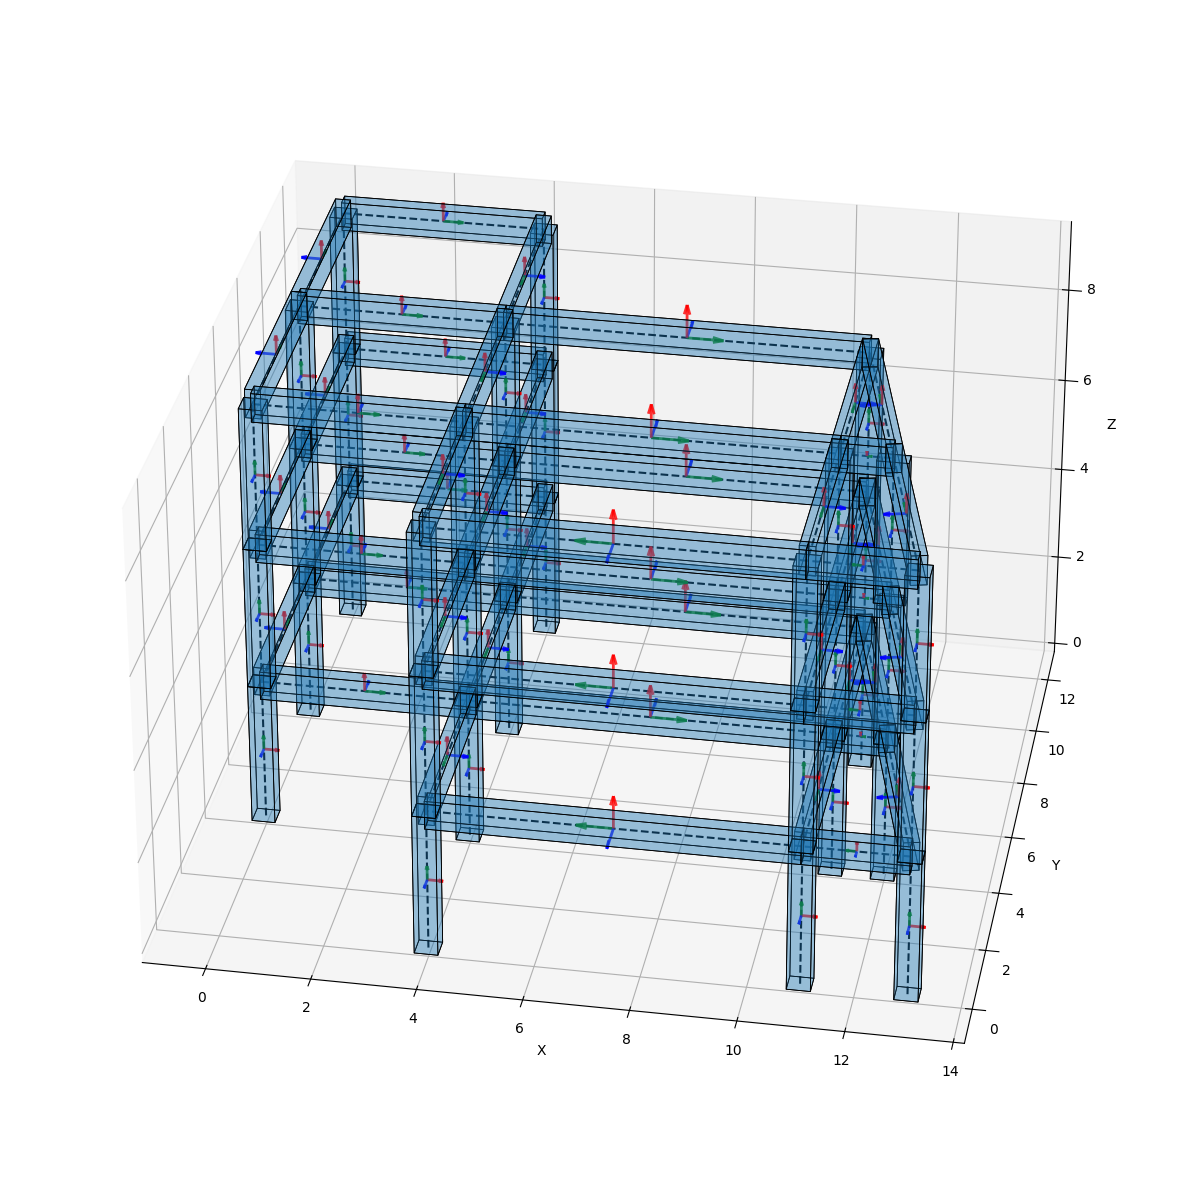

In [75]:
# ploteamos el modelo
n_elements = len(vigas) + len(nodos)
ele_shapes = {}
for i in range(n_elements):
    if i +1 < 36: # Column
        ele_shapes[i+1] = ['rect', [a, a]]
    else: # Beam
        ele_shapes[i+1] = ['rect', [h, b]]

opsv.plot_extruded_shapes_3d(ele_shapes, fig_wi_he=(30., 30.),az_el=(-80,30),fig_lbrt = (0, 0, 1, 1))
plt.show()

In [76]:
Nmodes = 9
vals = np.array(ops.eigen(Nmodes))
omega = np.sqrt(vals)
Tmodes = 2*np.pi/omega

for i in range(Nmodes):
    print("T[%i]: %.4f seg"%(i+1, Tmodes[i]))

T[1]: 0.1814 seg
T[2]: 0.1729 seg
T[3]: 0.1476 seg
T[4]: 0.0781 seg
T[5]: 0.0553 seg
T[6]: 0.0528 seg
T[7]: 0.0507 seg
T[8]: 0.0441 seg
T[9]: 0.0394 seg


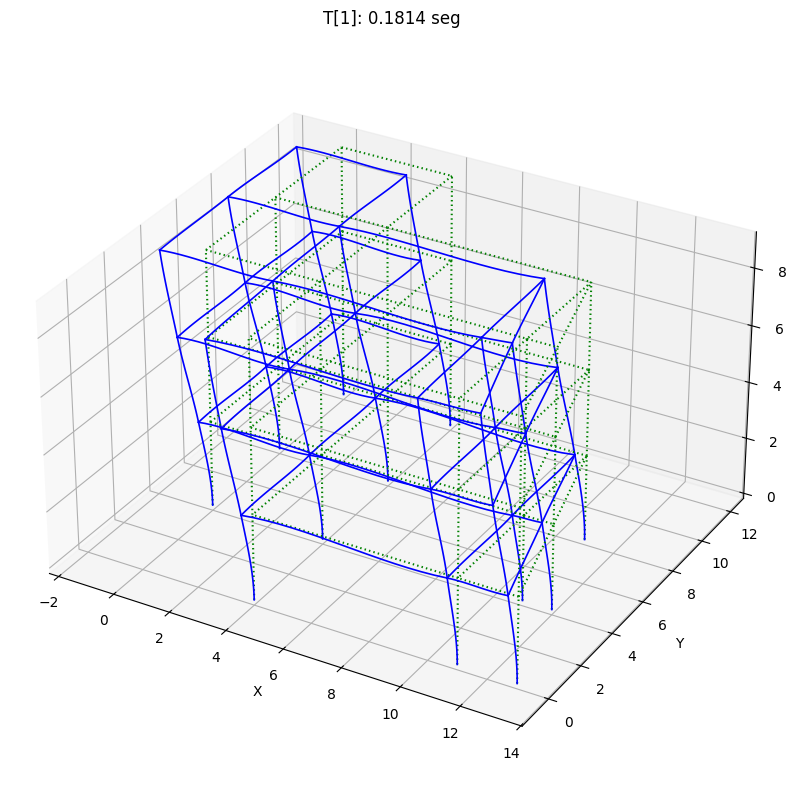

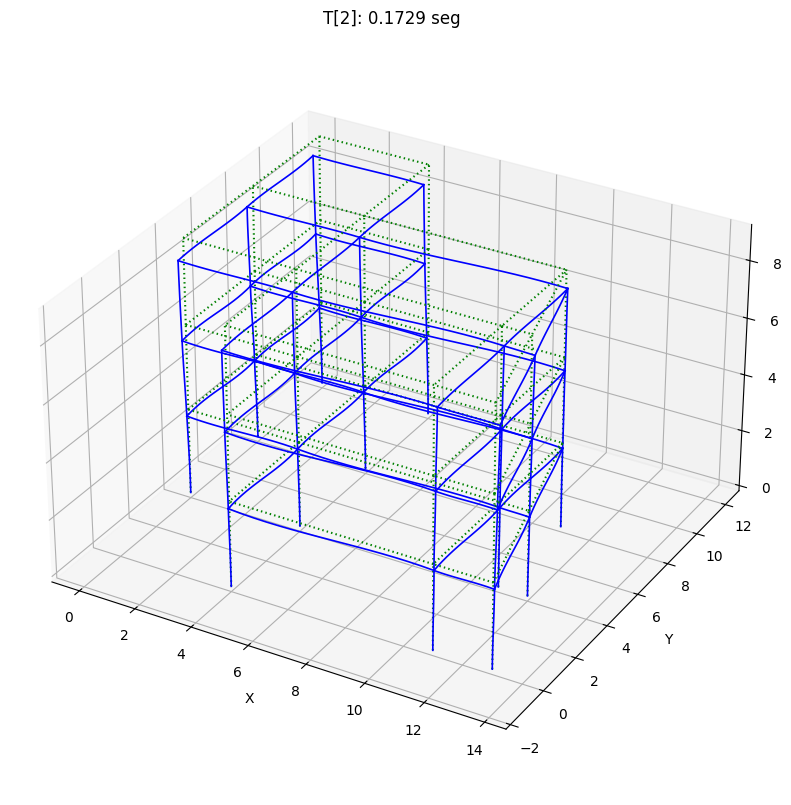

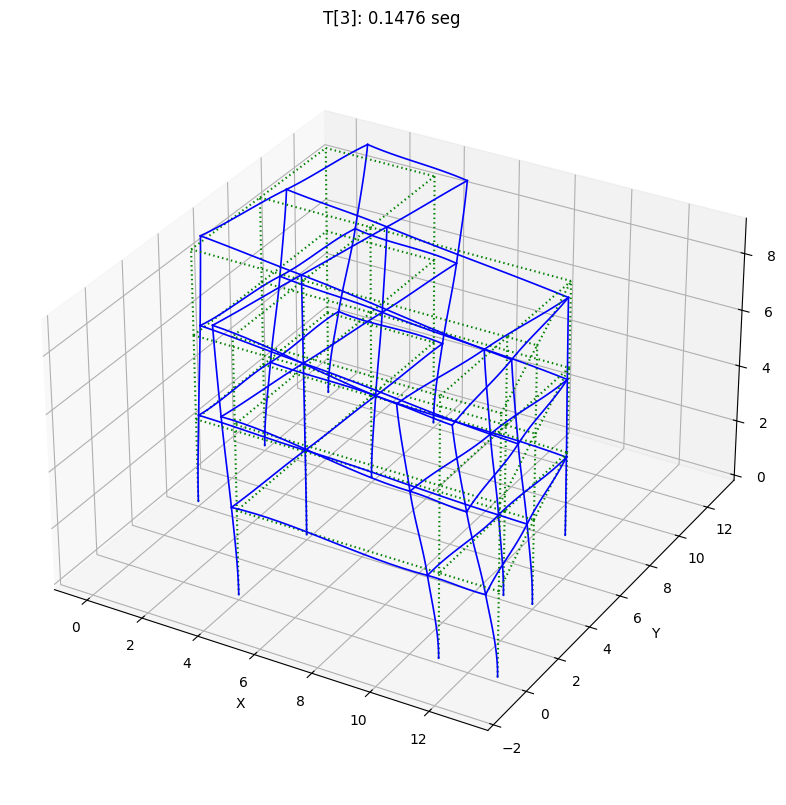

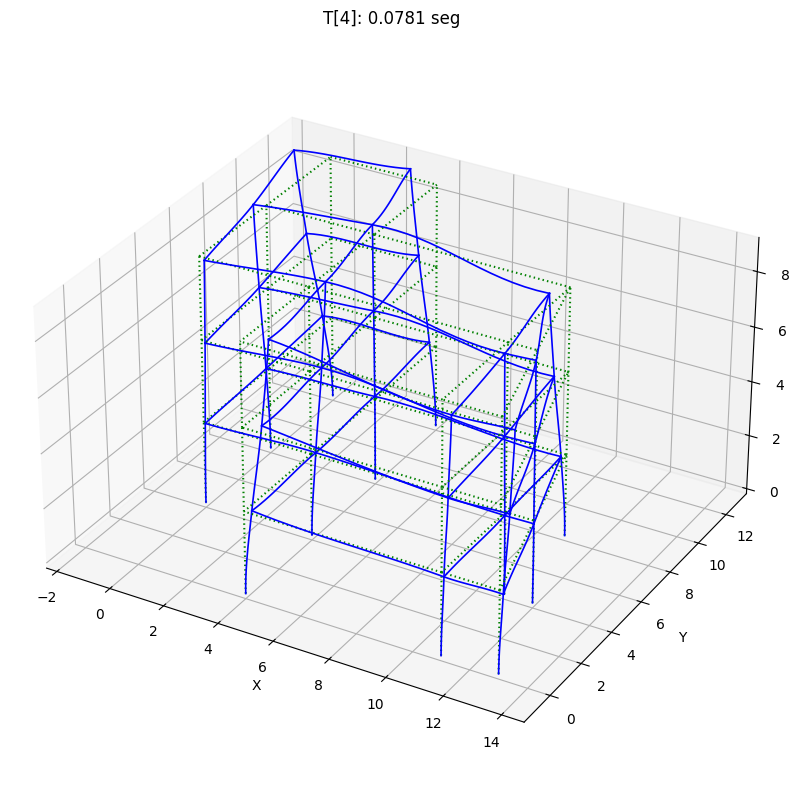

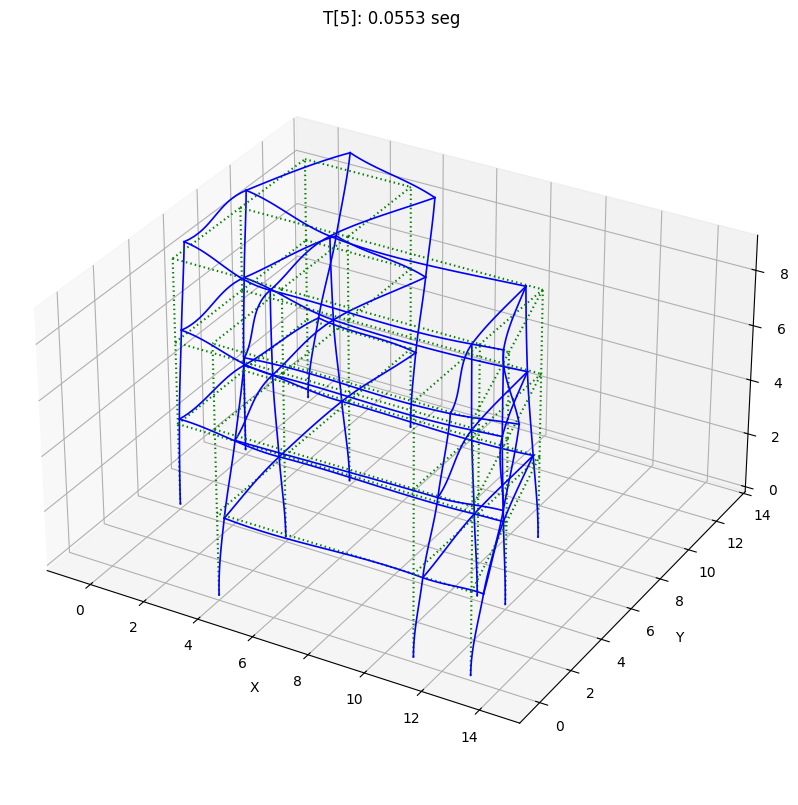

In [77]:
Nmode = 5
fmt_undefo={'color': 'green', 'linestyle': (0, (0.7, 1.5)), 'linewidth': 1.5, 'marker': '', 'markersize': 1}
for i in range(Nmode):
    opsv.plot_mode_shape(i+1, endDispFlag=0,fig_wi_he=(25,30),fmt_undefo=fmt_undefo, node_supports=False)
    plt.title("T[%i]: %.4f seg"%(i+1, Tmodes[i]))